In [1]:
import numpy  # needed (don't change it)
import importlib
import os
import socket
import sys

import datetime
import uuid
import argparse
from argparse import ArgumentParser
import matplotlib.pyplot as plt

import setproctitle
import torch
from datasets import NAMES as DATASET_NAMES
from datasets import ContinualDataset, get_dataset
from models import get_all_models, get_model

from utils.args import add_management_args
from utils.best_args import best_args
from utils.conf import set_random_seed
from utils.continual_training import train as ctrain
from utils.distributed import make_dp
from utils.training import train, mask_classes, evaluate

In [2]:
args_dict = {
        'dataset': 'seq-mnist',
        'model': 'cally',
        
        'buffer_size': 1000,
        'minibatch_size': 32,

        'lr': 0.01,
        'optim_wd': 0,
        'optim_mom': 0,
        'optim_nesterov': 0,
        'batch_size': 32,
        'n_epochs': 20,

        'distributed': 'no',
        'seed': 0,
        'validation': 0,
        'nowand': 1,
        'debug_mode': 0,
        'ignore_other_metrics': 0,
        'disable_log': 1,
        'non_verbose': 1,
        }

class C:
    pass
c = C()

args_list = []
parser = argparse.ArgumentParser()
for key in args_dict.keys():
    args_list.append('--' + key)
    
    if type(args_dict[key]) is str:
        parser.add_argument('--' + key, type=str)
        args_list.append(args_dict[key])
    elif type(args_dict[key]) is float:
        parser.add_argument('--' + key, type=float)
        args_list.append(str(args_dict[key]))
    elif type(args_dict[key]) is int:
        parser.add_argument('--' + key, type=int)
        args_list.append(str(args_dict[key]))

parser.parse_args(args=args_list, namespace=c)
args = c


### Setup

In [3]:
# Instance of Continual Dataset with 2 classes per task and 5 tasks
dataset = get_dataset(args)
# MLP with dimensions 784 -> 100,  100 -> 100, 100 -> 10
backbone = dataset.get_backbone()
# Loss is cross entropy
loss = dataset.get_loss()
# for MNIST transform = None
model = get_model(args, backbone, loss, dataset.get_transform())

### Experiment 1: Save all samples with positive associated dual variable.

In [4]:
# Compute initial Metrics for Knowledge Transfer Metrics
model.net.to(model.device)

dataset_copy = get_dataset(args)
for t in range(dataset.N_TASKS):
    model.net.train()
    _, _ = dataset_copy.get_data_loaders()
random_results_class, random_results_task = evaluate(model, dataset_copy)

# Results class: accuracy without masking
# Results task: accuracy when masking predictions (logits that are not the ones in current task go to -inf)
print(f"Random results class: {random_results_class} \nRandom results task: {random_results_task}")

Random results class: [0.04728132387706856, 10.822722820763957, 0.05336179295624333, 39.97985901309164, 0.2521432173474533] 
Random results task: [47.94326241134752, 50.53868756121449, 46.47812166488794, 52.215508559919435, 60.66565809379728]


In [5]:
# Each test loader only has images from specific task.
for i in range(5):
    print(numpy.unique(dataset_copy.test_loaders[i].dataset.targets))

[0 1]
[2 3]
[4 5]
[6 7]
[8 9]


In [6]:
results, results_mask_classes = [], []
#for t in range(dataset.N_TASKS):
t = 0

model.net.train()
# This gathers the dataloaders and increases the dataset.i attribute by 2 
train_loader, test_loader = dataset.get_data_loaders() 

if hasattr(model, 'begin_task'):
    model.begin_task(dataset)


In [7]:
scheduler = dataset.get_scheduler(model, args)

In [8]:
# Note that: model.buffer.num_seen_examples/model.args.n_epochs is the same as len(train_loader.dataset)

In [9]:
# Checking that Buffer is initially empty
print(f"The buffer is empty: {model.buffer.is_empty()}")

The buffer is empty: True


#### Train initial model: distinguish 0s from 1s.

In [10]:
for epoch in range(1):

    for i, data in enumerate(train_loader):

        inputs, labels, not_aug_inputs, indexes = data # REMEMBER: Indexes are task-dependent!
        inputs, labels = inputs.to(model.device), labels.to(model.device)
        not_aug_inputs = not_aug_inputs.to(model.device)
        loss = model.meta_observe(inputs, labels, not_aug_inputs, indexes)
        
    if scheduler is not None:
        scheduler.step()

In [11]:
accs = evaluate(model, dataset)
results.append(accs[0])
results_mask_classes.append(accs[1])
print(f"Results class: {results} \nResults task: {results_mask_classes}")

Results class: [[99.95271867612293]] 
Results task: [[99.95271867612293]]


Since I only trained with samples from one task, masking outputs from other tasks doesn't improve accuracy.

In [12]:
model.end_task(dataset)

1 space_per_class: [500. 500.   0.   0.   0.   0.   0.   0.   0.   0.]
2 space_per_class: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### Populate Buffer with samples that had a positive dual variable.

In [13]:
lambdas = model.lambdas.detach().cpu().numpy()
idxs_lambdas = (-lambdas).argsort()

Label = 0


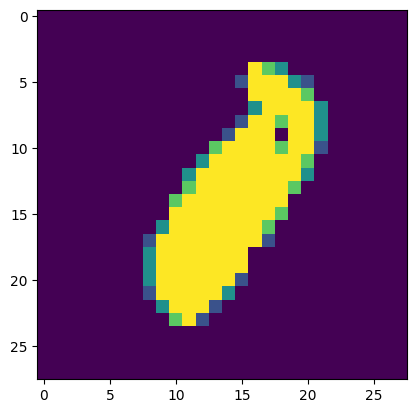

In [14]:
print(f"Label = {train_loader.dataset[idxs_lambdas[0]][1]}")
plt.imshow(train_loader.dataset[idxs_lambdas[0]][0].squeeze())

Percentage of samples with dual variables equal to 0: 0.0
Number of samples with non-zero dual variables: 12665


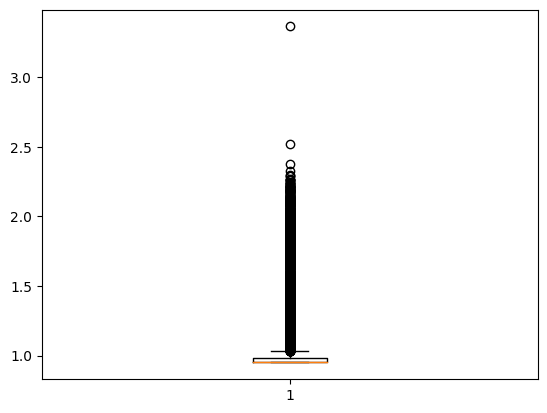

In [15]:
#thresh = 1e-30
_ = plt.boxplot(lambdas)
#_ = plt.hlines(thresh, xmin= 0, xmax =2, color = 'red')
num_zero = numpy.sum(lambdas == 0 )
print(f"Percentage of samples with dual variables equal to 0: {num_zero*100/len(lambdas)}")
print(f"Number of samples with non-zero dual variables: {len(lambdas)-num_zero}")

### Train on second task with populated buffer

In [29]:
model.net.train()
# This gathers the dataloaders and increases the dataset.i attribute by 2 
train_loader, test_loader = dataset.get_data_loaders() 

In [30]:
if hasattr(model, 'begin_task'):
    model.begin_task(dataset)

scheduler = dataset.get_scheduler(model, args)
# Checking that Buffer is not empty
print(f"The buffer is empty: {model.buffer.is_empty()}")

for epoch in range(1):

    for i, data in enumerate(train_loader):

        inputs, labels, not_aug_inputs, indexes = data # REMEMBER: Indexes are task-dependent!
        inputs, labels = inputs.to(model.device), labels.to(model.device)
        not_aug_inputs = not_aug_inputs.to(model.device)
        loss = model.meta_observe(inputs, labels, not_aug_inputs, indexes)

    if scheduler is not None:
        scheduler.step()

The buffer is empty: False


In [31]:
accs = evaluate(model, dataset)
results.append(accs[0])
results_mask_classes.append(accs[1])
print(f"Results class: {results} \nResults task: {results_mask_classes}")

Results class: [[99.95271867612293], [99.76359338061465, 88.93241919686582], [97.11583924349881, 91.42997061704212, 90.50160085378869], [95.46099290780143, 83.00685602350637, 95.67769477054429, 89.87915407854985]] 
Results task: [[99.95271867612293], [99.90543735224587, 96.5230166503428], [99.81087470449172, 95.73947110675807, 98.18569903948773], [99.8581560283688, 94.36826640548482, 98.77267876200641, 99.24471299093656]]


In [32]:
model.end_task(dataset)

 3 space_per_class: [  0.   0.   0.   0.   0.   0. 125. 125.   0.   0.]
 4 space_per_class: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 5 space_per_class: [125. 125. 125. 125. 125. 125.   0.   0.   0.   0.]
 6 space_per_class: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
sizes: 
torch.Size([750, 28, 28]) 750


In [28]:
model.buffer.num_seen_examples

996

In [20]:
lambdas = model.lambdas.detach().cpu().numpy()
buf_lambdas = model.buf_lambdas.detach().cpu().numpy()

Percentage of samples with dual variables equal to 0: 42.64207130449169
Number of samples with non-zero dual variables: 6934


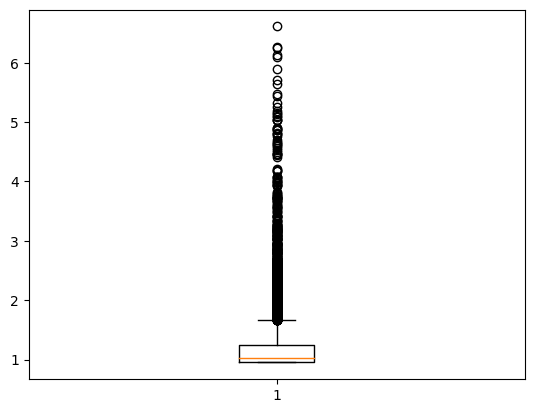

In [21]:
#thresh = 1e-30
_ = plt.boxplot(lambdas)
#_ = plt.hlines(thresh, xmin= 0, xmax =2, color = 'red')
num_zero = numpy.sum(lambdas < 1 )
print(f"Percentage of samples with dual variables equal to 0: {num_zero*100/len(lambdas)}")
print(f"Number of samples with non-zero dual variables: {len(lambdas)-num_zero}")

In [22]:
all_data = model.buffer.get_all_data()

In [23]:
all_data[0].shape

torch.Size([1000, 28, 28])